In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def stochastic_heun(f, g, y0, t0, t_end, h, **kwargs):
    """
    Heun method (order 1.0 strong) for SDEs:
    dy = f(t, y) dt + g(t, y) dW_t
    """

    ts = [t0]
    ys = [y0]
    t = t0
    y = y0

    while t < t_end:
        if t + h > t_end:
            h = t_end - t

        dW = np.random.normal(0.0, np.sqrt(h), size=(S))

        f0 = f(y, t, **kwargs)
        g0 = g(y, t, **kwargs)
        y_tilde = y + h * f0 + g0 * dW

        f1 = f(y_tilde, t + h, **kwargs)
        g1 = g(y_tilde, t + h, **kwargs)

        drift = 0.5 * (f0 + f1)
        diffusion = 0.5 * (g0 + g1)

        y = y + h * drift + diffusion * dW
        t += h

        ts.append(t)
        ys.append(y)

    return np.array(ts), np.array(ys)


In [3]:
def SGLV(x, t, W=None, r=1, thresh=1, **kwargs):
    if W is None:
        W = np.eye(len(x))
    out = r * (x - x*np.dot(W,x))
    out[out <= thresh] = 0
    return out

def mult_noise(x, t, sigma=1, thresh=1, **kwargs):
    x[x < thresh] = 0
    return sigma*x

def brown(x, t, **kwargs):
    return np.zeros(len(x))

def const_noise(x, t, sigma=1, **kwargs):
    return sigma * np.ones(len(x))
    

In [15]:
np.random.seed(1234)

# Parameters
S = 100
r = 0.1
mu, std = 2 / S**2, 1 / S**2
K = np.random.lognormal(6,size=(S))
A = np.random.rand(S,S)
W = np.random.normal(mu, std, size=(S,S))
W[A < 0.5] = 0
for i in range(S): W[i,i] = 1 / K[i]
sigma = 1 / np.sqrt(S)
thresh = 1

print(np.sum(W > 0) - S)

# Initial Conditions
y0 = 10 * np.random.rand(S)
t0 = 0.0
t_end = 1e4
dt = 0.1

# Solve SDE
# ts, ys = stochastic_heun(brown, const_noise, y0, t0, t_end, dt, sigma=sigma)
ts, ys = stochastic_heun(SGLV, mult_noise, y0, t0, t_end, dt, r=r, W=W, sigma=sigma, thresh=thresh)

4871


In [16]:
# Save data into DataFrame 
n_times, n_vars = ys.shape
df = pd.DataFrame({
    "time": np.repeat(ts, n_vars),
    "variable": np.tile([f"var_{i}" for i in range(n_vars)], n_times),
    "value": ys.flatten()
})

# Save to CSV
df.to_csv("./Data/synthetic/SGLV_dense.csv", index=False)

In [11]:
# Filter surviving species
indices = []
for i in range(S):
    if np.all(ys[:,i] > 0):
        indices.append(i)
surv_ys = ys[:,indices]
log_surv_ys = np.log(surv_ys)

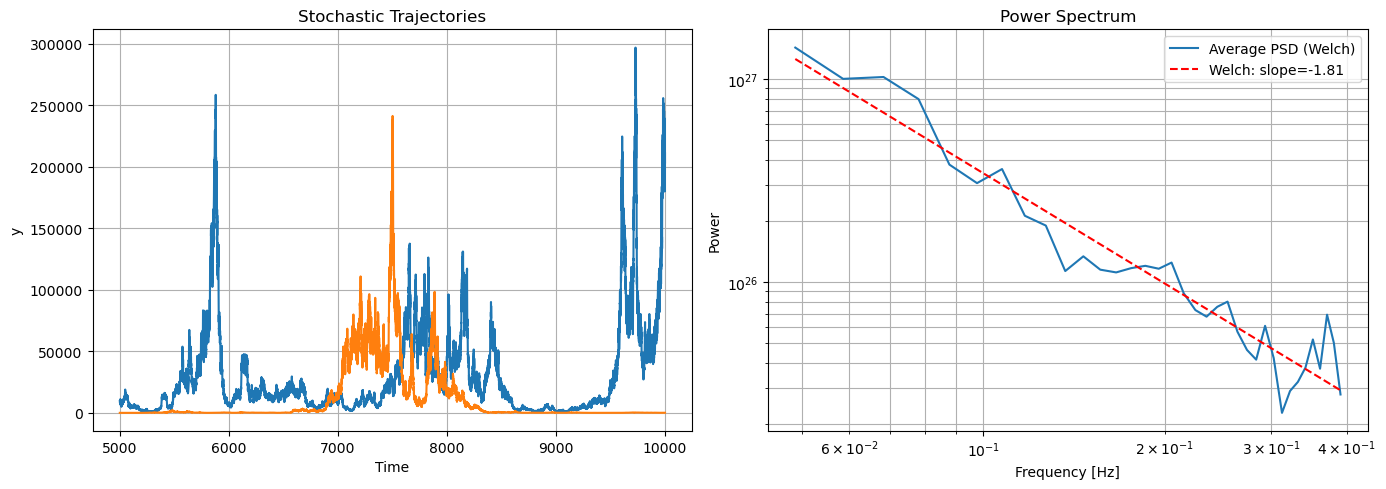

In [12]:
fs = 1.0 / dt # sampling frequency

nperseg = 1024

# Initialize sum of PSDs
idx = ts > 5000
frequencies, Pxx = sp.signal.welch(surv_ys[idx, 0], fs=fs, nperseg=nperseg)
mean_S = np.zeros_like(Pxx)

# Average Welch PSDs over all signals
for i in range(surv_ys.shape[1]):
    signal = surv_ys[idx, i]
    signal -= np.mean(signal)
    freqs, psd = sp.signal.welch(signal, fs=fs, nperseg=nperseg)
    mean_S += psd

mean_S /= surv_ys.shape[1]  # Average

# Discard frequencies which may contain big errors
f_low = 0.04
f_high = 0.4
mask = (frequencies > f_low) & (frequencies < f_high)
frequencies = frequencies[mask]
mean_S = mean_S[mask]

# Fit in log-log space
log_freqs = np.log10(frequencies)
log_psd = np.log10(mean_S)
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(log_freqs, log_psd)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plots
axs[0].plot(ts[idx], surv_ys[idx, 5])
axs[0].plot(ts[idx], surv_ys[idx, 3])
axs[0].set_xlabel("Time")
axs[0].set_ylabel("y")
axs[0].set_title("Stochastic Trajectories")
axs[0].grid(True, which="both")

axs[1].plot(frequencies, mean_S, label='Average PSD (Welch)')
axs[1].plot(frequencies, 10**(intercept + slope * log_freqs), 'r--', label=f'Welch: slope={slope:.2f}')
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("Power")
axs[1].set_title("Power Spectrum")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid(True, which="both")
axs[1].legend()

plt.tight_layout()
# plt.savefig("./Images/SGLV_sparse_PSD.png")
plt.show()


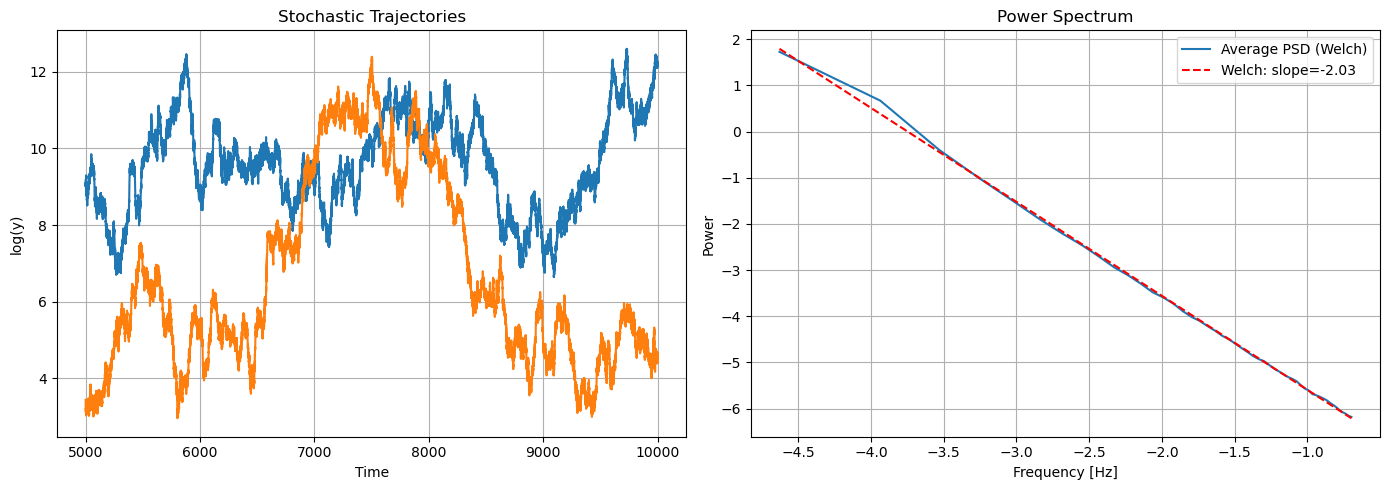

In [17]:
fs = 1.0 / dt # sampling frequency

nperseg = 1024

# Initialize sum of PSDs
idx = ts > 5000
frequencies, Pxx = sp.signal.welch(log_surv_ys[idx, 0], fs=fs, nperseg=nperseg)
mean_S = np.zeros_like(Pxx)

# Average Welch PSDs over all signals
for i in range(log_surv_ys.shape[1]):
    signal = log_surv_ys[idx, i]
    signal -= np.mean(signal)
    freqs, psd = sp.signal.welch(signal, fs=fs, nperseg=nperseg)
    mean_S += psd

mean_S /= log_surv_ys.shape[1]  # Average

# Discard frequencies which may contain big errors
f_low = 1e-3
f_high = 5e-1
mask = (frequencies > f_low) & (frequencies < f_high)
frequencies = frequencies[mask]
mean_S = mean_S[mask]

# Fit in log-log space
log_freqs = np.log(frequencies)
log_psd = np.log(mean_S)
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(log_freqs, log_psd)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plots
axs[0].plot(ts[idx], log_surv_ys[idx, 5])
axs[0].plot(ts[idx], log_surv_ys[idx, 3])
axs[0].set_xlabel("Time")
axs[0].set_ylabel("log(y)")
axs[0].set_title("Stochastic Trajectories")
axs[0].grid(True, which="both")

axs[1].plot(log_freqs, log_psd, label='Average PSD (Welch)')
axs[1].plot(log_freqs, intercept + slope * log_freqs, 'r--', label=f'Welch: slope={slope:.2f}')
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("Power")
axs[1].set_title("Power Spectrum")
axs[1].grid(True, which="both")
axs[1].legend()

plt.tight_layout()
# plt.savefig("./Images/log_SGLV_sparse_PSD.png")
plt.show()
